# Using the AnalyzeTimeSeries Class

This class contains a set of methods to create a database of data associated with KPF observations, as well as methods to ingest data, query the database, print data, and made time series plots.  An elaborate set of standard time series plots can be made over intervals of days/months/years/decades spanning a date range.  A related script 'ingest_kpf_ts_db.py' can be used to ingest data from the command line.
        
The ingested data comes from L0/2D/L1/L2 keywords and the TELEMETRY extension in L0 files.  With the current version of this code, all TELEMETRY keywords are added to the database an a small subset of the L0/2D/L1/L2 keywords are added. These lists can be expanded, but will require re-ingesting the data (which takes about half a day for all KPF observations).  RVs are currently not ingested, but that capability should be added.

The first step is importing packages.

In [1]:
from modules.quicklook.src.analyze_time_series import AnalyzeTimeSeries
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import numpy as np
import time
import matplotlib.dates as mdates
from datetime import datetime
from astropy.table import Table

## Database Ingestion

The AnalyzeTimeSeries class uses an sqlite3 database stored in a file.  It is is initiated as shown below.  As you can see, the database is fresh because the file `kpf_ts.db` didn't exist.

In [2]:
db_path = 'kpf_ts.db' # name of database file
myTS = AnalyzeTimeSeries(db_path=db_path)

INFO: Starting AnalyzeTimeSeries
INFO: Jupyter Notebook environment detected.
INFO: Path of database file: /code/KPF-Pipeline/docs/source/tutorials/kpf_ts.db
INFO: Base data directory: /data/L0
INFO: Summary: 952 obs x 280 cols over 3 days in 20231201-20231224; updated 2024-04-09 01:55:28


Data can be ingested into the database using several methods.  The first method is one observation at a time.

In [3]:
myTS.ingest_one_observation('/data/L0/20231224/','KP.20231224.78695.16.fits')
myTS.print_db_status()

INFO: Summary: 952 obs x 280 cols over 3 days in 20231201-20231224; updated 2024-04-09 01:55:28


Second, one can ingest over a range of dates.

In [4]:
start_date = '20231201'
end_date   = '20231202'
myTS = AnalyzeTimeSeries(db_path=db_path)
myTS.ingest_dates_to_db(start_date, end_date)
myTS.print_db_status()

INFO: Starting AnalyzeTimeSeries
INFO: Jupyter Notebook environment detected.
INFO: Path of database file: /code/KPF-Pipeline/docs/source/tutorials/kpf_ts.db
INFO: Base data directory: /data/L0
INFO: Summary: 952 obs x 280 cols over 3 days in 20231201-20231224; updated 2024-04-09 01:55:28
INFO: Adding to database between 20231201 to 20231202


20231201:   0%|          | 0/2 [00:00<?, ?it/s]

Files:   0%|          | 0/345 [00:00<?, ?it/s]

Files:   0%|          | 0/606 [00:00<?, ?it/s]

INFO: Summary: 952 obs x 280 cols over 3 days in 20231201-20231224; updated 2024-04-09 01:55:28


The other ingestion methods (not shown) include ingesting based on the ObsIDs from a file (`add_ObsID_list_to_db`) and using the commandline script `KPF-Pipeline/scripts/ingest_kpf_tsdb.py`.

## Database Querying and Display

The database can be queried and displayed.

In [5]:
myTS = AnalyzeTimeSeries(db_path=db_path)
columns_to_display = ['ObsID', 'OBJECT', 'DATE-MID', 'DRPTAG']
myTS.display_dataframe_from_db(columns_to_display)

INFO: Starting AnalyzeTimeSeries
INFO: Jupyter Notebook environment detected.
INFO: Path of database file: /code/KPF-Pipeline/docs/source/tutorials/kpf_ts.db
INFO: Base data directory: /data/L0
INFO: Summary: 952 obs x 280 cols over 3 days in 20231201-20231224; updated 2024-04-09 01:55:28
                    ObsID            OBJECT                 DATE-MID  DRPTAG
0    KP.20231224.78695.16             SoCal  2023-12-24T21:51:41.172  v2.5.3
1    KP.20231201.04036.28      autocal-bias  2023-12-01T01:07:16.285  v2.5.3
2    KP.20231201.00046.92  autocal-flat-all  2023-12-01T00:01:01.932  v2.5.3
3    KP.20231201.03986.43      autocal-bias  2023-12-01T01:06:26.457  v2.5.3
4    KP.20231201.00125.73  autocal-flat-all  2023-12-01T00:02:20.736  v2.5.3
..                    ...               ...                      ...     ...
947  KP.20231202.86055.54  autocal-flat-all  2023-12-02T23:54:30.546  v2.5.3
948  KP.20231202.86134.34  autocal-flat-all  2023-12-02T23:55:49.356  v2.5.3
949  KP.20231202.

Or converted into a Pandas dataframe for manipulation or for making custom plots.

In [6]:
df = myTS.dataframe_from_db(columns_to_display)

## Plotting Telemetry

The AnalyzeTimeSeries has a built-in plotting library that uses dictionaries to pass information.  Here's and example.  Note that `start_date` and `end_date` are formatted as datetime objects, not strings as above.

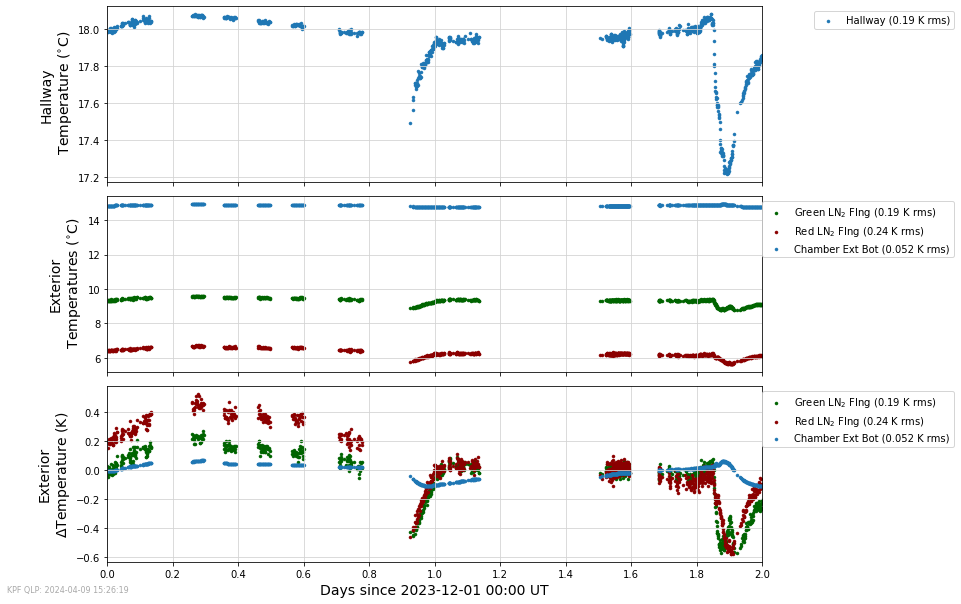

In [7]:
start_date = datetime(2023,12, 1)
end_date   = datetime(2023,12, 3)
dict1 = {'col': 'kpfmet.TEMP',              'plot_type': 'scatter', 'unit': 'K', 'plot_attr': {'label':  'Hallway',              'marker': '.', 'linewidth': 0.5}}
dict2 = {'col': 'kpfmet.GREEN_LN2_FLANGE',  'plot_type': 'scatter', 'unit': 'K', 'plot_attr': {'label': r'Green LN$_2$ Flng',    'marker': '.', 'linewidth': 0.5, 'color': 'darkgreen'}}
dict3 = {'col': 'kpfmet.RED_LN2_FLANGE',    'plot_type': 'scatter', 'unit': 'K', 'plot_attr': {'label': r'Red LN$_2$ Flng',      'marker': '.', 'linewidth': 0.5, 'color': 'darkred'}}
dict4 = {'col': 'kpfmet.CHAMBER_EXT_BOTTOM','plot_type': 'scatter', 'unit': 'K', 'plot_attr': {'label': r'Chamber Ext Bot',      'marker': '.', 'linewidth': 0.5}}
dict5 = {'col': 'kpfmet.CHAMBER_EXT_TOP',   'plot_type': 'plot',    'unit': 'K', 'plot_attr': {'label': r'Chamber Exterior Top', 'marker': '.', 'linewidth': 0.5}}
thispanelvars = [dict1]
thispaneldict = {'ylabel': 'Hallway\n' + r' Temperature ($^{\circ}$C)',
                 'legend_frac_size': 0.3}
halltemppanel = {'panelvars': thispanelvars,
                 'paneldict': thispaneldict}

thispanelvars2 = [dict2, dict3, dict4]
thispaneldict2 = {'ylabel': 'Exterior\n' + r' Temperatures ($^{\circ}$C)',
                 'legend_frac_size': 0.3}
halltemppanel2 = {'panelvars': thispanelvars2,
                  'paneldict': thispaneldict2}

thispanelvars3 = [dict2, dict3, dict4]
thispaneldict3 = {'ylabel': 'Exterior\n' + r'$\Delta$Temperature (K)',
                 'subtractmedian': 'true',
                 'legend_frac_size': 0.3}
halltemppanel3 = {'panelvars': thispanelvars3,
                  'paneldict': thispaneldict3}

panel_arr = [halltemppanel, halltemppanel2, copy.deepcopy(halltemppanel3)]
myTS.plot_time_series_multipanel(panel_arr, start_date=start_date, end_date=end_date, show_plot=True, clean=True)

There are also a number of built-in standard plots.  As of this writing, the standard plots are listed below.  Examples of two of them are also shown below.

Standard plots: `chamber_temp`, `chamber_temp_detail`, `fiber_temp`, `ccd_readnoise`, `ccd_dark_current`, `ccd_readspeed`, `ccd_controller`, `ccd_temp`, `lfc`, `etalon`, `hcl`, `hk_temp`, `agitator`, `guiding`, `seeing`, `sun_moon`.

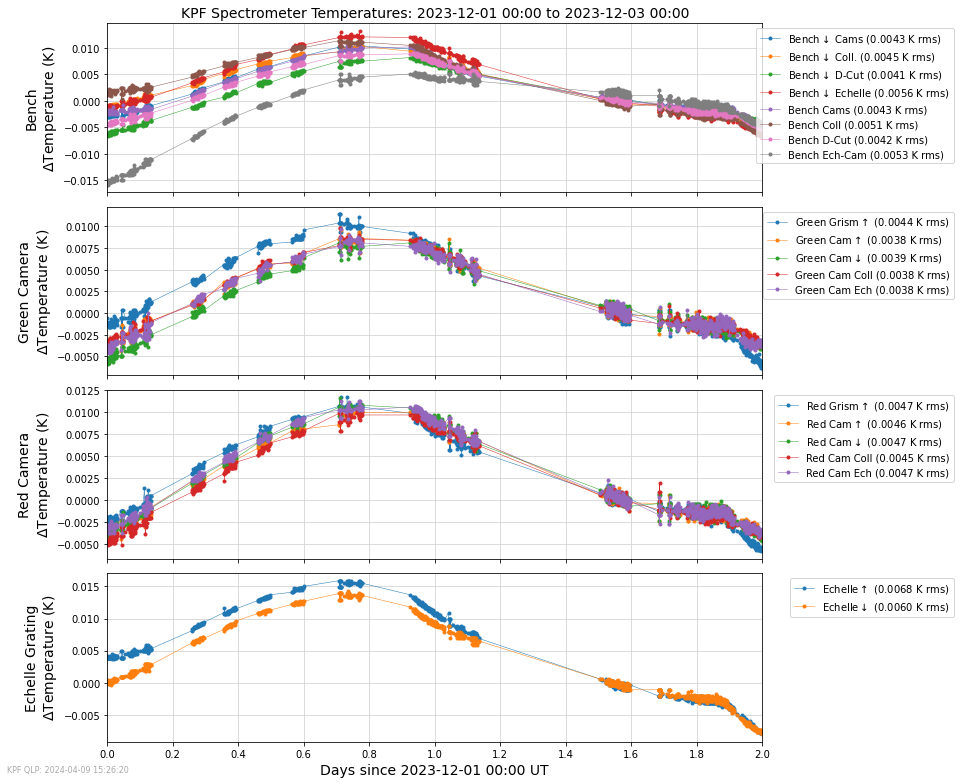

In [8]:
myTS.plot_standard_time_series('chamber_temp_detail', start_date=start_date, end_date=end_date, show_plot=True, clean=True)

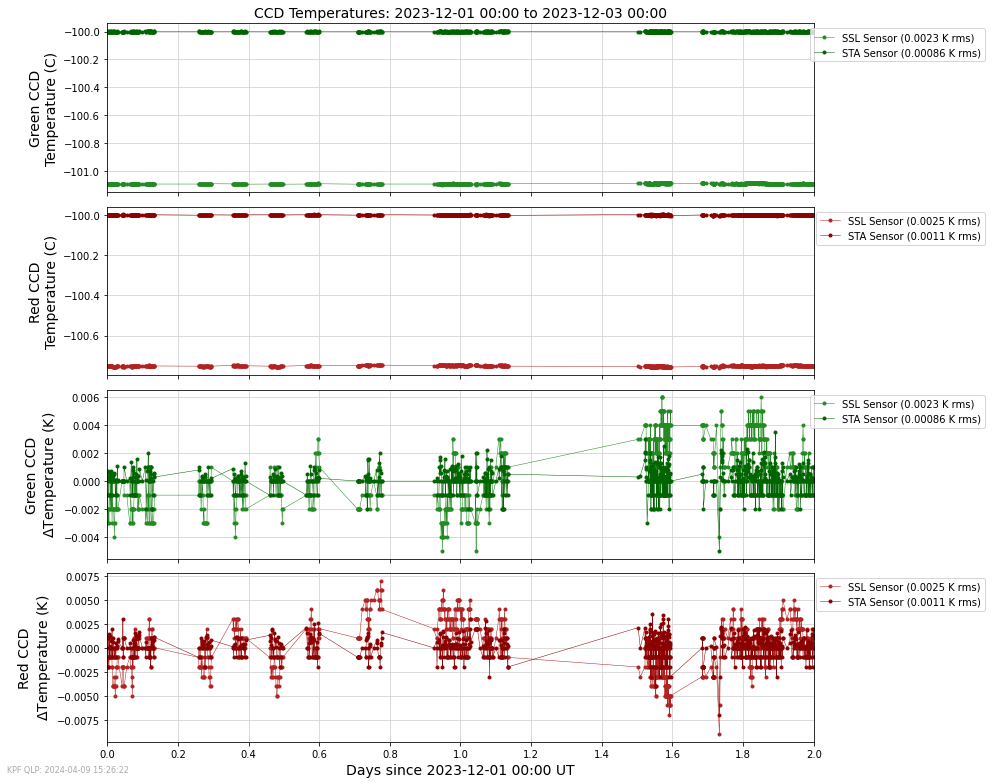

In [9]:
myTS.plot_standard_time_series('ccd_temp', start_date=start_date, end_date=end_date, show_plot=True, clean=True)

One can also generate all plots from the `plot_all_quicklook_daterange()` method with a single call.  The line below is commented out because it generates a large number of plots (a few dozen) that are too much output for this tutorial.  Change `if False` to `if True:` in the line below in your own notebook to generate the output.

In [10]:
if False:
    myTS = AnalyzeTimeSeries(db_path=db_path)
    myTS.plot_all_quicklook(datetime(2023, 12, 1), interval='day', show_plot=True)

## Plotting RVs

An example of plotting RVs (instead of telemetry) is shown below.

In [11]:
myTS.plot_standard_time_series('autocal_rv', start_date=start_date, end_date=end_date, show_plot=True, clean=True)

ERROR: plot_name not specified
